# Recap on collaborative filtering



In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os.path as op

from zipfile import ZipFile
try:
    from urllib.request import urlretrieve
except ImportError:  # Python 2 compat
    from urllib import urlretrieve

# this line need to be changed:
data_folder = '/home/lelarge/courses/data/'

ML_100K_URL = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
# dataset for exercise: ML_100K_URL = "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
ML_100K_FILENAME = op.join(data_folder,ML_100K_URL.rsplit('/', 1)[1])
ML_100K_FOLDER = op.join(data_folder,'ml-100k')
# for exercise: ML_100K_FOLDER = op.join(data_folder,'ml-latest-small')

if not op.exists(ML_100K_FILENAME):
    print('Downloading %s to %s...' % (ML_100K_URL, ML_100K_FILENAME))
    urlretrieve(ML_100K_URL, ML_100K_FILENAME)

if not op.exists(ML_100K_FOLDER):
    print('Extracting %s to %s...' % (ML_100K_FILENAME, ML_100K_FOLDER))
    ZipFile(ML_100K_FILENAME).extractall(data_folder)

In [38]:
import pandas as pd

all_ratings = pd.read_csv(op.join(ML_100K_FOLDER, 'u.data'), sep='\t',
                          names=["user_id", "item_id", "ratings", "timestamp"])
#all_ratings = pd.read_csv(op.join(ML_100K_FOLDER, 'ratings.csv'), names=["user_id", "item_id", "ratings", "timestamp"])
#all_ratings = all_ratings.iloc[1:]
all_ratings.head()

,user_id,item_id,ratings,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [39]:
# number of unique users
total_user_id = len(all_ratings['user_id'].unique())
# number of unique rated items
total_item_id = len(all_ratings['item_id'].unique())

In [40]:
print(total_user_id,total_item_id)

943 1682


In [41]:
from sklearn.model_selection import train_test_split

ratings_train, ratings_test = train_test_split(
    all_ratings, test_size=0.2, random_state=42)

user_id_train = ratings_train['user_id']
item_id_train = ratings_train['item_id']
rating_train = ratings_train['ratings']

user_id_test = ratings_test['user_id']
item_id_test = ratings_test['item_id']
rating_test = ratings_test['ratings']

In [42]:
len(user_id_train)

80000

In [43]:
user_ids_train_np = user_id_train.as_matrix().astype(np.int32)
item_ids_train_np = item_id_train.as_matrix().astype(np.int32)
ratings_train_np = rating_train.as_matrix().astype(np.float32)
user_ids_test_np = user_id_test.as_matrix().astype(np.int32)
item_ids_test_np = item_id_test.as_matrix().astype(np.int32)
ratings_test_np = rating_test.as_matrix().astype(np.float32)

# 1. Latent factors

In [46]:
import imp
import torch
import ExplicitFactorizationModel; imp.reload(ExplicitFactorizationModel)
from ExplicitFactorizationModel import ExplicitFactorizationModel
from torch_utils import l1_loss

model = ExplicitFactorizationModel(embedding_dim=128,  # latent dimensionality
                                   n_iter=10,  # number of epochs of training
                                   batch_size=1024,  # minibatch size
                                   learning_rate=1e-3,
                                   l2=1e-9,  # strength of L2 regularization
                                   use_cuda=torch.cuda.is_available(),
                                   num_users=total_user_id+1,
                                   num_items=total_item_id+1,
                                  loss = l1_loss)

In [47]:
model.fit(user_ids_train_np, item_ids_train_np, ratings_train_np,
          user_ids_test_np, item_ids_test_np, ratings_test_np)

Epoch 0: train loss 3.433351634423944 validation loss 3.1805217266082764
Epoch 1: train loss 2.2792865535880944 validation loss 1.2223896980285645
Epoch 2: train loss 0.9320487727092791 validation loss 0.8157238960266113
Epoch 3: train loss 0.7758862595014935 validation loss 0.767008364200592
Epoch 4: train loss 0.7447243544119823 validation loss 0.7544935941696167
Epoch 5: train loss 0.7322373095946976 validation loss 0.7485127449035645
Epoch 6: train loss 0.7251424193382263 validation loss 0.7453478574752808
Epoch 7: train loss 0.7205137791512888 validation loss 0.7440184950828552
Epoch 8: train loss 0.7166207410112212 validation loss 0.7419171929359436
Epoch 9: train loss 0.7123639787299724 validation loss 0.7399391531944275


# 2. Analyze results

We will use standard ML tools to interpret the embeddings found by our algorithm. We first need to retrive the weights of these embedding in a numpy format.

In [48]:
user_emb_np = model._net.user_embeddings.weight.data.numpy()
item_emb_np = model._net.item_embeddings.weight.data.numpy()

In [69]:
df = pd.read_csv(op.join(ML_100K_FOLDER, 'u.item'), sep='|', names=['item_id', 'item_name','date','','','','','','','','','','','','','','','','','','','','',''],encoding = "ISO-8859-1")
movies_names = df.loc[:,['item_id', 'item_name']]
movies_names = movies_names.set_index(['item_id'])
movies_names.head()

,item_name
item_id,
1,Toy Story (1995)
2,GoldenEye (1995)
3,Four Rooms (1995)
4,Get Shorty (1995)
5,Copycat (1995)


In [70]:
item_bias_np = model._net.item_biases.weight.data.numpy()
movies_names['biases'] = pd.Series(item_bias_np[1:].T[0], index=movies_names.index)
movies_names.head()

,item_name,biases
item_id,,
1,Toy Story (1995),0.144332
2,GoldenEye (1995),0.104207
3,Four Rooms (1995),0.108118
4,Get Shorty (1995),0.132367
5,Copycat (1995),0.122503


In [97]:
movies_names.loc[181,'item_name']

'Return of the Jedi (1983)'

In [75]:
movies_names.shape

(1682, 2)

In [76]:
indices_item_train = np.sort(item_id_train.unique())
movies_names = movies_names.loc[indices_item_train]
movies_names.shape

(1653, 2)

In [77]:
movies_names = movies_names.sort_values(ascending=False,by=['biases'])
movies_names.head(10)

,item_name,biases
item_id,,
1449,Pather Panchali (1955),0.193085
318,Schindler's List (1993),0.184110
50,Star Wars (1977),0.183018
313,Titanic (1997),0.181763
302,L.A. Confidential (1997),0.180590
408,"Close Shave, A (1995)",0.173482
98,"Silence of the Lambs, The (1991)",0.172756
1367,Faust (1994),0.172586
258,Contact (1997),0.172082


In [78]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(item_emb_np.T).components_

In [79]:
fac0 = movie_pca[0]

In [80]:
item_comp = [(f, movies_names.loc[i,'item_name']) for f,i in zip(fac0, indices_item_train)]

In [81]:
import operator;
sorted(item_comp, key=operator.itemgetter(0))[:10]

[(-0.039170924812999178, 'Love Is All There Is (1996)'),
 (-0.036591398253310543, 'Jack (1996)'),
 (-0.035975656129045117, 'Women, The (1939)'),
 (-0.035953147306115686, "What's Eating Gilbert Grape (1993)"),
 (-0.035854620041910285, 'Legends of the Fall (1994)'),
 (-0.035190706041507314, 'Everyone Says I Love You (1996)'),
 (-0.035131349432276929, 'Maltese Falcon, The (1941)'),
 (-0.035072966166677426, 'Cinema Paradiso (1988)'),
 (-0.034830320428416058, 'Lost World: Jurassic Park, The (1997)'),
 (-0.034757531454045573, 'Mighty Aphrodite (1995)')]

In [82]:
sorted(item_comp, key=operator.itemgetter(0), reverse=True)[:10]

[(0.00022278062324490729, 'To Cross the Rubicon (1991)'),
 (0.00020199907888976092, "Brother's Kiss, A (1997)"),
 (0.00015604172997444639, 'Tom and Huck (1995)'),
 (0.00013888542365372904, 'All Things Fair (1996)'),
 (0.00012661833868734174, 'Innocents, The (1961)'),
 (9.412886139281163e-05, 'Reluctant Debutante, The (1958)'),
 (8.9756015564764049e-05, 'Infinity (1996)'),
 (8.7181100653360217e-05, 'Rough Magic (1995)'),
 (5.658774029294733e-05, 'Baton Rouge (1988)'),
 (5.562500870938808e-05, 'The Deadly Cure (1996)')]

In [83]:
fac1 = movie_pca[1]
item_comp = [(f, movies_names.loc[i,'item_name']) for f,i in zip(fac1, indices_item_train)]

In [84]:
sorted(item_comp, key=operator.itemgetter(0))[:10]

[(-0.044908300483816235, 'Trainspotting (1996)'),
 (-0.043286358173719633, 'Heavy (1995)'),
 (-0.040515890020430781, 'Ben-Hur (1959)'),
 (-0.038260017895498939, 'Swiss Family Robinson (1960)'),
 (-0.035231077071173983, 'Fog, The (1980)'),
 (-0.035091961816535559, 'Pump Up the Volume (1990)'),
 (-0.034415051515388893, 'Rebel Without a Cause (1955)'),
 (-0.033783304375090507, 'Mr. Smith Goes to Washington (1939)'),
 (-0.033540125004606146, 'Lost Horizon (1937)'),
 (-0.032976751763785686, 'Blues Brothers, The (1980)')]

In [85]:
sorted(item_comp, key=operator.itemgetter(0), reverse=True)[:10]

[(0.10774604447482694, 'In & Out (1997)'),
 (0.10112485031121665, 'Air Bud (1997)'),
 (0.0963508666434061, 'Breakdown (1997)'),
 (0.096026390694110841, 'Game, The (1997)'),
 (0.094631365382265867, "Dante's Peak (1997)"),
 (0.094507626572563869, 'Jackal, The (1997)'),
 (0.093791269675655084, 'Lost Highway (1997)'),
 (0.092500534905404774, 'Chasing Amy (1997)'),
 (0.091522028475543235, 'Desperate Measures (1998)'),
 (0.09066202832083857, 'Evita (1996)')]

In [86]:
fac2 = movie_pca[2]

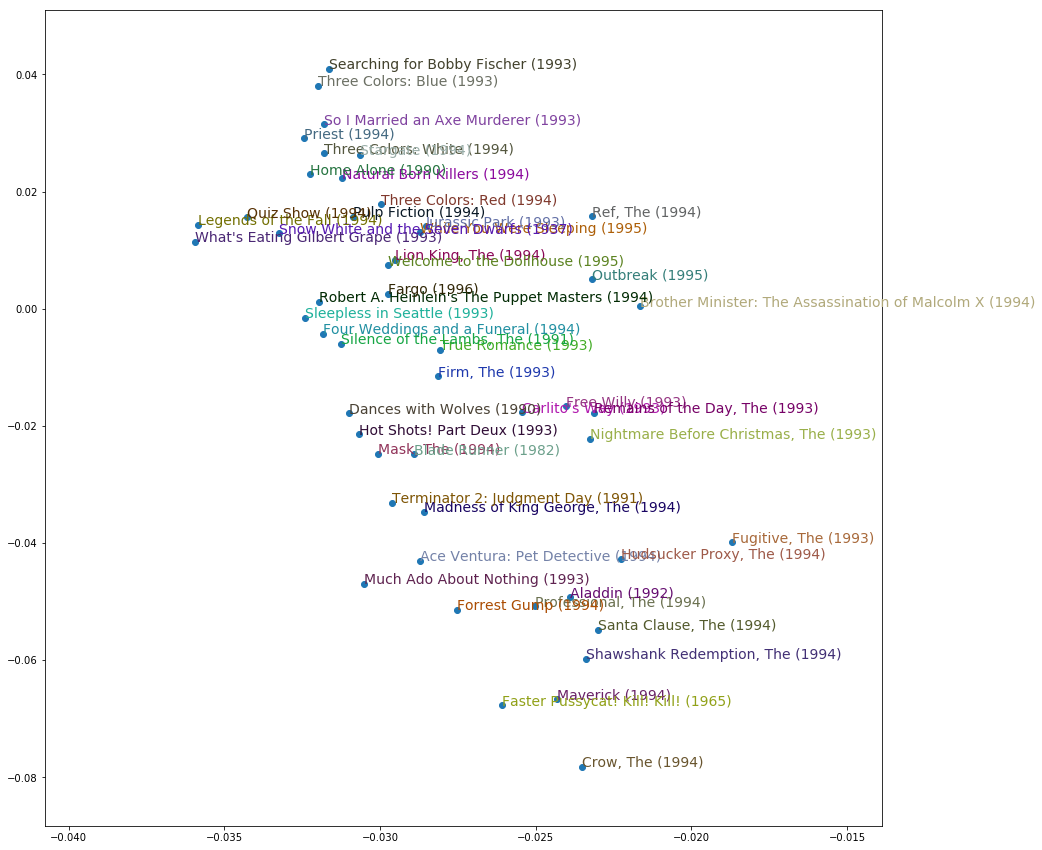

In [91]:
start=50; end=100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(indices_item_train[start:end], X, Y):
    plt.text(x,y,movies_names.loc[i,'item_name'], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

## Exercise

Previous analysis is not very convincing. Redo it with the dataset ml-latest-small.zip

This dataset contains much more movies and less users. Each user rated at least 20 movies.

To make the analysis of the factors more interesting, restrict it to the top 2000 most popular movies.

You should obtain something like:

![PCA movies](pca_movies.png)

# 3. Neural Net (MLP)

In [92]:
import models; imp.reload(models)
from models import DeepModel
import ExplicitFactorizationModel; imp.reload(ExplicitFactorizationModel)
from ExplicitFactorizationModel import ExplicitFactorizationModel
from torch_utils import l1_loss

model_deep = ExplicitFactorizationModel(embedding_dim=30,  # latent dimensionality
                                   n_iter=10,  # number of epochs of training
                                   batch_size=64,  # minibatch size
                                   learning_rate=1e-3,
                                   l2=0,  # strength of L2 regularization
                                   use_cuda=torch.cuda.is_available(),
                                   num_users=total_user_id+1,
                                   num_items=total_item_id+1,
                                   net=DeepModel(total_user_id+1,total_item_id+1,30),
                                       loss=l1_loss)

In [93]:
model_deep.fit(user_ids_train_np, item_ids_train_np, ratings_train_np,
          user_ids_test_np, item_ids_test_np, ratings_test_np)

Epoch 0: train loss 1.004701142835617 validation loss 0.923172652721405
Epoch 1: train loss 0.9199592028141022 validation loss 0.9158885478973389
Epoch 2: train loss 0.9139914298057557 validation loss 0.9112852811813354
Epoch 3: train loss 0.9120474348545075 validation loss 0.9111989736557007
Epoch 4: train loss 0.9102239940643311 validation loss 0.9086740612983704
Epoch 5: train loss 0.9098483894348145 validation loss 0.9092984795570374
Epoch 6: train loss 0.9082104542732239 validation loss 0.9061316847801208
Epoch 7: train loss 0.9076204085350037 validation loss 0.9078764319419861
Epoch 8: train loss 0.906849817276001 validation loss 0.909491777420044
Epoch 9: train loss 0.9068227844715119 validation loss 0.9110423922538757


In [94]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

test_preds = model.predict(user_ids_test_np, item_ids_test_np)
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))

Final test MSE: 0.936
Final test MAE: 0.740


In [95]:
test_preds_deep = model_deep.predict(user_ids_test_np, item_ids_test_np)
print("Final test MSE: %0.3f" % mean_squared_error(test_preds_deep, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds_deep, rating_test))

Final test MSE: 1.480
Final test MAE: 0.909


In [96]:
print(model_deep._net)

DeepModel (
  (user_embeddings): Embedding(944, 30)
  (item_embeddings): Embedding(1683, 30)
  (fc1): Linear (60 -> 64)
  (fc2): Linear (64 -> 32)
  (fcf): Linear (32 -> 1)
)


## Exercise

Add another layer and compare.

### Finding most similar items
Finding k most similar items to a point in embedding space

- Write in numpy a function to compute the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) between two points in embedding space
- Write a function which computes the euclidean distance between a point in embedding space and all other points
- Write a most similar function, which returns the k item names with lowest euclidean distance / highest cosine similarity.
- Try with a movie index, such as 181 (Return of the Jedi). What do you observe? Don't expect miracles on such a small training set but still give your results on the forum!

Notes:
- you may use `np.linalg.norm` to compute the norm of vector, and you may specify the `axis=`
- the numpy function `np.argsort(...)` enables to compute the sorted indices of a vector

## 4. Implicit Feedback

## The Triplet Loss

The following section demonstrates how to build a recommender system when only positive feedbacks are availables.

The similarity score between a user and an item is defined by the unormalized dot products of their respective embeddings.

The matching scores can be use to rank items to recommend to a specific user.

Training of the model parameters is achieved by randomly sampling negative items not seen by a pre-selected anchor user. We want the model embedding matrices to be such that the similarity between the user vector and the negative vector is smaller than the similarity between the user vector and the positive item vector. Furthermore we use a margin to further move appart the negative from the anchor user.

Here is the architecture of such a triplet architecture. The triplet name comes from the fact that the loss to optimize is defined for triple `(anchor_user, positive_item, negative_item)`:

<img src="rec_archi_implicit_2.svg" style="width: 600px;" />

We call this model a triplet model with bi-linear interactions because the similarity between a user and an item is captured by a dot product of the first level embedding vectors. This is therefore not a deep architecture.

In [99]:
data_train = pd.read_csv(op.join(ML_100K_FOLDER, 'ua.base'), sep='\t',
                        names=["user_id", "item_id", "rating", "timestamp"])
data_test = pd.read_csv(op.join(ML_100K_FOLDER, 'ua.test'), sep='\t',
                        names=["user_id", "item_id", "rating", "timestamp"])

data_train.describe()

,user_id,item_id,rating,timestamp
count,90570.000000,90570.000000,90570.000000,9.057000e+04
mean,461.494038,428.104891,3.523827,8.835073e+08
std,266.004364,333.088029,1.126073,5.341684e+06
min,1.000000,1.000000,1.000000,8.747247e+08
25%,256.000000,174.000000,3.000000,8.794484e+08
50%,442.000000,324.000000,4.000000,8.828143e+08
75%,682.000000,636.000000,4.000000,8.882049e+08
max,943.000000,1682.000000,5.000000,8.932866e+08


We consider ratings >= 4 as positive feed back and ignore the rest.

In [100]:
pos_data_train = data_train.query("rating >= 4")
pos_data_test = data_test.query("rating >= 4")

In [101]:
pos_data_train['rating'].count()

49906

In [102]:
pos_data_test['rating'].count()

5469

In [103]:
pos_user_train_np = pos_data_train['user_id'].as_matrix().astype(np.int32)
pos_item_train_np = pos_data_train['item_id'].as_matrix().astype(np.int32)
user_train_np = data_train['user_id'].as_matrix().astype(np.int32)
item_train_np = data_train['item_id'].as_matrix().astype(np.int32)
rating_train_np = data_train['rating'].as_matrix().astype(np.float32)
user_test_np = data_test['user_id'].as_matrix().astype(np.int32)
item_test_np = data_test['item_id'].as_matrix().astype(np.int32)
rating_test_np = data_test['rating'].as_matrix().astype(np.float32)

In [104]:
import torch_utils; imp.reload(torch_utils)
import ImplicitFactorizationModel; imp.reload(ImplicitFactorizationModel)
from ImplicitFactorizationModel import ImplicitFactorizationModel

## Exercise

You will need to complete some pieces of code in the ImplicitFactorizationModel.py file in order to run the rest of this notebook.

In [105]:
model_triplet = ImplicitFactorizationModel(embedding_dim=128,  # latent dimensionality
                                   n_iter=1,  # number of epochs of training
                                   batch_size=1024,  # minibatch size
                                   learning_rate=0,
                                   l2=1e-9,  # strength of L2 regularization
                                   use_cuda=torch.cuda.is_available(),
                                   num_users=total_user_id+1,
                                   num_items=total_item_id+1)

In [106]:
model_triplet.fit(pos_user_train_np,pos_item_train_np)

Epoch 0: train loss 1.0000049094764554


## Quality of Ranked Recommendations

Now that we have a randomly initialized model we can start computing random recommendations. To assess their quality we do the following for each user:

- compute matching scores for items (except the movies that the user has already seen in the training set),
- compare to the positive feedback actually collected on the test set using the [ROC AUC ranking metric](http://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics),
- average ROC AUC scores across users to get the average performance of the recommender model on the test set.

In [107]:
from sklearn.metrics import roc_auc_score


def average_roc_auc(model, data_train, data_test):
    """Compute the ROC AUC for each user and average over users"""
    max_user_id = max(data_train['user_id'].max(), data_test['user_id'].max())
    max_item_id = max(data_train['item_id'].max(), data_test['item_id'].max())
    user_auc_scores = []
    for user_id in range(1, max_user_id + 1):
        pos_item_train = data_train[data_train['user_id'] == user_id]
        pos_item_test = data_test[data_test['user_id'] == user_id]
        
        # Consider all the items already seen in the training set
        all_item_ids = np.arange(1, max_item_id + 1)
        items_to_rank = np.setdiff1d(all_item_ids, pos_item_train['item_id'].values)
        
        # Ground truth: return 1 for each item positively present in the test set
        # and 0 otherwise.
        expected = np.in1d(items_to_rank, pos_item_test['item_id'].values)
        
        if np.sum(expected) >= 1:
            # At least one positive test value to rank
            repeated_user_id = np.empty_like(items_to_rank)
            repeated_user_id.fill(user_id)

            predicted = model.predict(repeated_user_id, items_to_rank)
            user_auc_scores.append(roc_auc_score(expected, predicted))

    return sum(user_auc_scores) / len(user_auc_scores)

In [108]:
average_roc_auc(model_triplet, pos_data_train, pos_data_test)

0.50538861083660758

In [109]:
model_triplet = ImplicitFactorizationModel(embedding_dim=128,  # latent dimensionality
                                   n_iter=15,  # number of epochs of training
                                   batch_size=1024,  # minibatch size
                                   learning_rate=1e-3,
                                   l2=1e-9,  # strength of L2 regularization
                                   use_cuda=torch.cuda.is_available(),
                                   num_users=total_user_id+1,
                                   num_items=total_item_id+1)

In [110]:
model_triplet.fit(pos_user_train_np,pos_item_train_np)

Epoch 0: train loss 0.9823946271623883
Epoch 1: train loss 0.8564361942057707
Epoch 2: train loss 0.4616966478678645
Epoch 3: train loss 0.36813849818949795
Epoch 4: train loss 0.34802813128549226
Epoch 5: train loss 0.3301108856590427
Epoch 6: train loss 0.3178681208162892
Epoch 7: train loss 0.30968122153866046
Epoch 8: train loss 0.29373539771352497
Epoch 9: train loss 0.28728836714004985
Epoch 10: train loss 0.2740917297042146
Epoch 11: train loss 0.2633976839026626
Epoch 12: train loss 0.25793141978127615
Epoch 13: train loss 0.2510903413806643
Epoch 14: train loss 0.24905629973022306


In [111]:
test_preds = model_triplet.predict(user_test_np, item_test_np)
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test_np))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test_np))

Final test MSE: 7.715
Final test MAE: 2.551


In [112]:
train_preds = model_triplet.predict(user_train_np, item_train_np)
print("Final test MSE: %0.3f" % mean_squared_error(train_preds, rating_train_np))
print("Final test MAE: %0.3f" % mean_absolute_error(train_preds, rating_train_np))

Final test MSE: 7.642
Final test MAE: 2.561


In [113]:
average_roc_auc(model_triplet, pos_data_train, pos_data_test)

0.91938412414258475

## Exercise: Training a Deep Matching Model on Implicit Feedback


Instead of using hard-coded cosine similarities to predict the match of a `(user_id, item_id)` pair, we can instead specify a deep neural network based parametrisation of the similarity. The parameters of that matching model are also trained with the margin comparator loss:

<img src="rec_archi_implicit_1.svg" style="width: 600px;" />

Code such a deep model and evaluate it.